In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### Cargamos el dataset

In [3]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Eliminamos las columnas que no son predicturas

In [4]:
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

Creamos cageogoricas

In [6]:
df = pd.get_dummies(df)
del df['Sex_female']
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,False,True
1,1,1,38.0,1,0,71.2833,False,True,False,False
2,1,3,26.0,0,0,7.9250,False,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,False,True


### Pequeña exploración de datos

In [7]:
df.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,,,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.852459,0.136612,0.085610,0.777778
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.318713,0.271930,0.087719,0.634503


Quitamos los NA's

In [8]:
df.isna().mean()

Survived      0.000000
Pclass        0.000000
Age           0.198653
SibSp         0.000000
Parch         0.000000
Fare          0.000000
Sex_male      0.000000
Embarked_C    0.000000
Embarked_Q    0.000000
Embarked_S    0.000000
dtype: float64

In [9]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

### Crea un modelo 

In [12]:
target = 'Survived'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

c:\Users\epile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Predicciones del modelo, cuales son los tipos que hay 

In [13]:
probas = model.predict_proba(X_test)

probabilidades = [i[1] for i in probas]
predicciones = model.predict(X_test)

calibracion = pd.DataFrame({
    'target': y_test,
    'probabilidades': probabilidades,
    'predicciones': predicciones
})

calibracion

,target,probabilidades,predicciones
495,0,0.207432,0
648,0,0.117217,0
278,0,0.075825,0
31,1,0.938704,1
255,1,0.708300,1
...,...,...,...
263,0,0.364247,0
718,0,0.143332,0
620,0,0.167833,0
786,1,0.699103,1


### Calibracion

In [17]:
calibracion['bins'] = pd.qcut(calibracion['probabilidades'], q=10, labels=False) +1

grouped = calibracion.groupby('bins').mean()

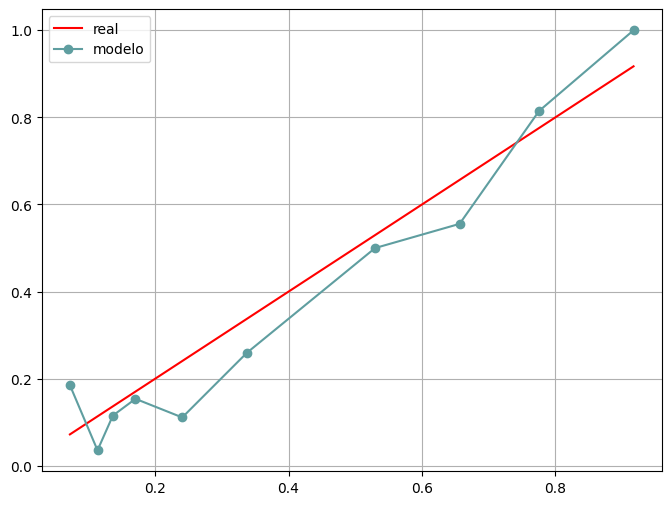

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(grouped['probabilidades'], grouped['probabilidades'], label='real', color='red')
plt.plot(grouped['probabilidades'], grouped['target'], marker='o', label='modelo', color='cadetblue')
plt.legend(loc='best')
plt.grid()
plt.show()

### ¿Qué tanto le atina?

In [ ]:
np.mean(calibracion['predicciones'] == calibracion['target'])

0.8022388059701493

Con sklearn 

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred=calibracion['predicciones'], y_true=calibracion['target'])

0.8022388059701493

###  Histogramas 

In [25]:
prob_1 = calibracion[calibracion['target'] == 1]['probabilidades']
prob_2 = calibracion[calibracion['target'] == 0]['probabilidades']

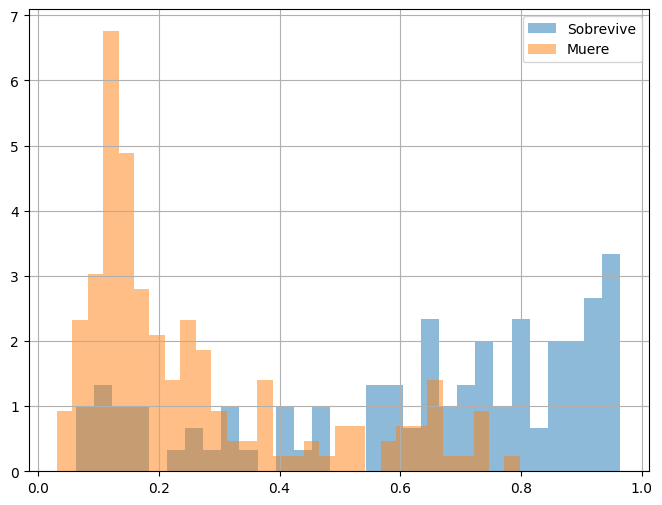

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(prob_1, alpha=0.5, density=True,  label='Sobrevive', bins = 30)
plt.hist(prob_2, alpha=0.5, density=True,  label='Muere',  bins = 30)
plt.legend(loc='best')
plt.grid()
plt.show()

### Usando statsmodel

In [32]:
import statsmodels.formula.api as smf
df = pd.read_csv('titanic.csv')

In [33]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [34]:
df.keys()

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [36]:
model = smf.logit('Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6


In [37]:
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,4.4329,0.536,8.271,0.000,3.383,5.483
C(Pclass)[T.2],-1.1896,0.329,-3.614,0.000,-1.835,-0.544
C(Pclass)[T.3],-2.3952,0.343,-6.976,0.000,-3.068,-1.722
C(Sex)[T.male],-2.6379,0.223,-11.829,0.000,-3.075,-2.201
C(Embarked)[T.Q],-0.8234,0.600,-1.372,0.170,-2.000,0.353
C(Embarked)[T.S],-0.4028,0.275,-1.467,0.142,-0.941,0.135
Age,-0.0433,0.008,-5.204,0.000,-0.060,-0.027
SibSp,-0.3629,0.129,-2.807,0.005,-0.616,-0.110
Parch,-0.0604,0.124,-0.487,0.626,-0.303,0.183
Fare,0.0015,0.003,0.559,0.576,-0.004,0.007
